[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/annanasnas/semantic_segmentation-25/blob/main/DeepLabV2.ipynb)

In [ ]:
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
REPO = "https://github.com/annanasnas/semantic_segmentation-25.git"
!git clone $REPO
%cd /content/semantic_segmentation-25
!pip install -q -r requirements.txt pyyaml

Cloning into 'semantic_segmentation-25'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (199/199), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 199 (delta 95), reused 154 (delta 53), pack-reused 0 (from 0)
Receiving objects: 100% (199/199), 736.19 KiB | 8.46 MiB/s, done.
Resolving deltas: 100% (95/95), done.
/content/semantic_segmentation-25
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Config

In [ ]:
import yaml

with open("configs/augmentations.yaml", "r", encoding="utf-8") as f:
    cfg = yaml.safe_load(f)

!python scripts/download_data.py

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = cfg["train"]["batch_size"]
epochs = cfg["train"]["epochs"]
learning_rate = cfg["train"]["lr"]

dir_train = cfg["data"]["dir_train"]
dir_val = cfg["data"]["dir_val"]
img_size_train = tuple(cfg["data"]["img_size_train"])
img_size_val = tuple(cfg["data"]["img_size_val"])

name = cfg["model"]["name"]

## DataLoaders

In [ ]:
from datasets.cityscapes import CityScapes
from datasets.gta5 import GTA5Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# augmenations
image_aug_transforms_1 = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

image_aug_transforms_2 = A.Compose([
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

image_aug_transforms_3 = A.Compose([
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])

image_aug_transforms_4 = A.Compose([
    A.RandomScale(scale_limit=(0.0, 0.5), p=0.5),
    A.PadIfNeeded(min_height=720, min_width=1280,
                  border_mode=cv2.BORDER_CONSTANT,
                  value=0,
                  mask_value=255),
    A.RandomCrop(height=720, width=1280, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(5, 5), p=0.5),
    A.Normalize(mean=imagenet_mean, std=imagenet_std),
    ToTensorV2()
])



/tmp/ipython-input-4-4184819555.py:21: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=720, min_width=1280,
/tmp/ipython-input-4-4184819555.py:45: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=720, min_width=1280,


In [ ]:
train_dataset_1 = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_aug_transforms_1,
    image_size=img_size_train
)

train_dataset_2 = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_aug_transforms_2,
    image_size=img_size_train
)

train_dataset_3 = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_aug_transforms_3,
    image_size=img_size_train
)

train_dataset_4 = GTA5Dataset(
    root_dir=dir_train,
    image_transform=image_aug_transforms_4,
    image_size=img_size_train
)

val_dataset = CityScapes(
    root_dir=dir_val,
    split="val",
    image_transform=image_transforms,
    image_size=img_size_val
)

train_dataloader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True, num_workers=2)
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True, num_workers=2)
train_dataloader_3 = DataLoader(train_dataset_3, batch_size=batch_size, shuffle=True, num_workers=2)
train_dataloader_4 = DataLoader(train_dataset_4, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

## Training

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import torch.optim as optim
import torch.nn as nn
from models.bisenet.build_bisenet import BiSeNet
from scripts.train import train_model
from torch.amp import autocast, GradScaler
from scripts.checkpoint import Checkpoint
from scripts.utils import denormalize
from pathlib import Path
import pandas as pd
from PIL import Image
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt


criterion = nn.CrossEntropyLoss(ignore_index=255)

def augmentation_model(aug_name):
    model = BiSeNet(num_classes=19, context_path='resnet18')
    optimizer = optim.SGD(model.optim_parameters(lr=learning_rate), momentum=0.9, weight_decay=5e-4)
    scaler = GradScaler()

    model.to(device)

    ckpt_dir = Path("/content/drive/MyDrive/semantic segmentation/checkpoints") / name / aug_name
    log_csv  = ckpt_dir / "log.csv"
    ckpt_mgr = Checkpoint(ckpt_dir)
    ckpt = Checkpoint(ckpt_dir)

    best_path = ckpt_dir / "best.pth"
    if best_path.exists():
        ckpt = torch.load(best_path, map_location="cpu", weights_only=False)
        model.load_state_dict(ckpt["model"])
        optimizer.load_state_dict(ckpt["optimizer"])
        scaler.load_state_dict(ckpt["scaler"])
        start_epoch = ckpt["epoch"]
        iteration = ckpt["iteration"]
        best_miou   = ckpt["best_miou"]
        df_prev = pd.read_csv(log_csv)
        metrics = df_prev.to_dict("list")
    else:
        start_epoch = 0
        best_miou   = 0
        iteration = 0
        metrics = {"epoch": [], "train_loss": [], "val_loss": [], "val_miou": []}

    return model, optimizer, scaler, start_epoch, iteration, best_miou, metrics, ckpt_mgr, log_csv


def visualize_augmentation(dataloader, img_size, image_transform):

    ds = dataloader.dataset
    idx = random.randrange(len(ds))
    img_path = ds.image_paths[idx]

    img_raw = Image.open(img_path).convert("RGB")

    img_aug = transforms.Resize((img_size))(img_raw)
    img_aug_t = image_transform(image=np.array(img_aug))
    img_aug_out  = TF.to_pil_image(denormalize(img_aug_t["image"]))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img_raw); ax[0].set_title("Original");   ax[0].axis("off")
    ax[1].imshow(img_aug_out); ax[1].set_title("Augmented");  ax[1].axis("off")
    plt.tight_layout(); plt.show()



### Augmentation 1

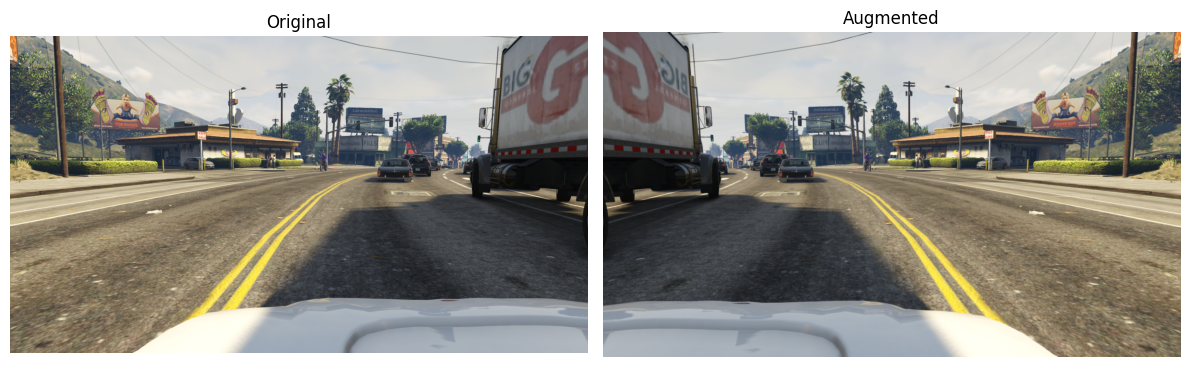

In [ ]:
visualize_augmentation(train_dataloader_1, img_size_train, image_aug_transforms_1)

In [ ]:
max_iter = len(train_dataloader_1) * epochs
model, optimizer, scaler, start_epoch, iteration, best_miou, metrics, ckpt_mgr, log_csv = augmentation_model("augmentation1")

train_model(model, train_dataloader_1, val_dataloader,
            device, epochs, autocast, scaler,
            optimizer, criterion, learning_rate,
            iteration, max_iter,
            ckpt_mgr, start_epoch, best_miou,
            log_csv, metrics)

### Augmentation 2

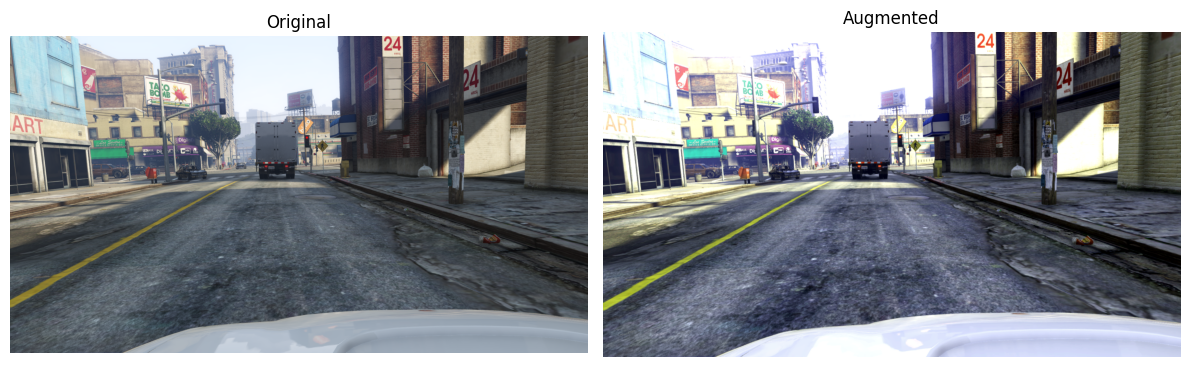

In [ ]:
visualize_augmentation(train_dataloader_2, img_size_train, image_aug_transforms_2)

In [ ]:
max_iter = len(train_dataloader_2) * epochs
model, optimizer, scaler, epoch, iteration, best_mio, metrics, ckpt_mgr, log_csv = augmentation_model("augmentation2")

train_model(model, train_dataloader_2, val_dataloader,
            device, epochs, autocast, scaler,
            optimizer, criterion, learning_rate,
            iteration, max_iter,
            ckpt_mgr, start_epoch, best_miou,
            log_csv, metrics)

### Augmentation 3

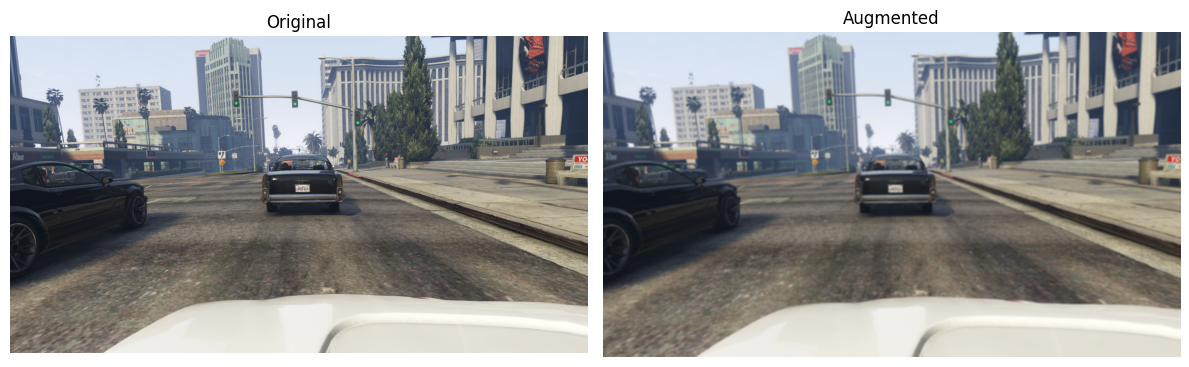

In [ ]:
visualize_augmentation(train_dataloader_3, img_size_train, image_aug_transforms_3)

In [ ]:
max_iter = len(train_dataloader_3) * epochs
model, optimizer, scaler, epoch, iteration, best_mio, metrics, ckpt_mgr, log_csv = augmentation_model("augmentation3")

train_model(model, train_dataloader_3, val_dataloader,
            device, epochs, autocast, scaler,
            optimizer, criterion, learning_rate,
            iteration, max_iter,
            ckpt_mgr, start_epoch, best_miou,
            log_csv, metrics)

### Augmentation 1, 2 and 3

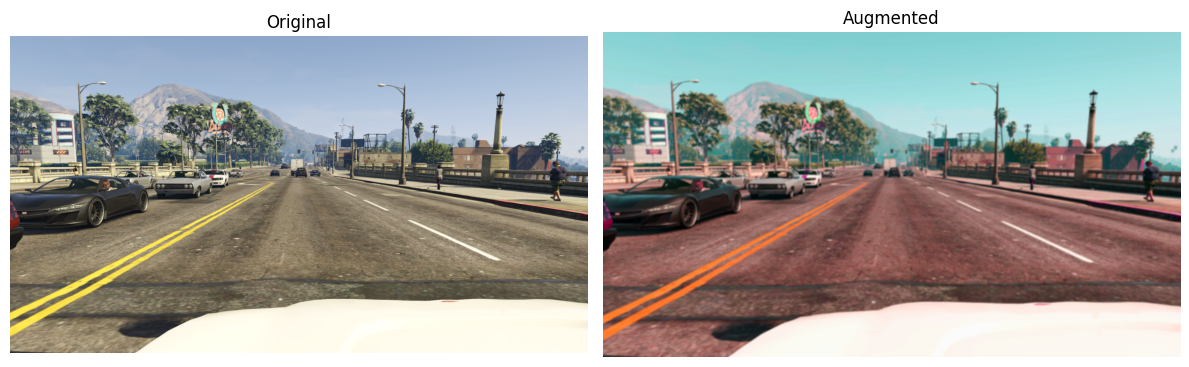

In [ ]:
visualize_augmentation(train_dataloader_4, img_size_train, image_aug_transforms_4)

In [ ]:
max_iter = len(train_dataloader_4) * epochs
model, optimizer, scaler, epoch, iteration, best_mio, metrics, ckpt_mgr, log_csv = augmentation_model("augmentation4")

train_model(model, train_dataloader_4, val_dataloader,
            device, epochs, autocast, scaler,
            optimizer, criterion, learning_rate,
            iteration, max_iter,
            ckpt_mgr, start_epoch, best_miou,
            log_csv, metrics)

# Results

In [ ]:
from scripts.utils import evaluate_miou

CITYSCAPES_CLASSES = [
    'Road', 'Sidewalk', 'Building', 'Wall', 'Fence', 'Pole', 'Traffic light',
    'Traffic sign', 'Vegetation', 'Terrain', 'Sky', 'Person', 'Rider', 'Car',
    'Truck', 'Bus', 'Train', 'Motorcycle', 'Bicycle'
]

MODELS = {
    "Augmentation 1":     {"ckpt": "/content/drive/MyDrive/semantic segmentation/checkpoints/bisenet (data augmentations)/augmentation1/best.pth"},
    "Augmentation 2":     {"ckpt": "/content/drive/MyDrive/semantic segmentation/checkpoints/bisenet (data augmentations)/augmentation2/best.pth"},
    "Augmentation 3":     {"ckpt": "/content/drive/MyDrive/semantic segmentation/checkpoints/bisenet (data augmentations)/augmentation3/best.pth"},
    "Augmentation 1+2+3": {"ckpt": "/content/drive/MyDrive/semantic segmentation/checkpoints/bisenet (data augmentations)/augmentation4/best.pth"},
}

rows = []
for name, cfg in MODELS.items():
    model = BiSeNet(num_classes=19, context_path='resnet18').to(device)
    best_model = torch.load(cfg["ckpt"], map_location=device)
    model.load_state_dict(best_model["model_state_dict"]) #model
    ious = evaluate_miou(model, val_dataloader, device) * 100
    rows.append([name, *ious, np.nanmean(ious)])

columns = ["Model", *CITYSCAPES_CLASSES, "mIoU"]
iou_table = pd.DataFrame(rows, columns=columns).set_index("Model")

print(iou_table.round(2))


                     Road  Sidewalk  Building   Wall  Fence   Pole  \
Model                                                                
Augmentation 1       8.43      5.23     55.49   2.59  11.62  10.54   
Augmentation 2      61.79     30.84     75.44   8.32  11.19  20.93   
Augmentation 3      32.29      9.84     65.51   6.72  11.91  15.84   
Augmentation 1+2+3  58.41     27.04     77.40  18.33  20.37  23.35   

                    Traffic light  Traffic sign  Vegetation  Terrain    Sky  \
Model                                                                         
Augmentation 1              16.26          4.88       58.77     3.92  40.58   
Augmentation 2              14.49          8.51       71.98    13.90  70.67   
Augmentation 3              15.09          9.07       70.00     7.11  48.55   
Augmentation 1+2+3          20.89         16.20       76.58    19.25  73.96   

                    Person  Rider    Car  Truck   Bus  Train  Motorcycle  \
Model                       